In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
from pathlib import Path  # python3 only
import math,datetime
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
state = 'Texas'
keyword = 'transgender'
year = str(2021)
currentYear = datetime.datetime.now().year
trendAnalysis = pd.DataFrame(columns = ['Phrase','Frequency','Counties'])


In [19]:
keyWords = ['China','mexican','hispanic','black people','immigrant','muslim','transgender','asian','chinese','gay']
# keyWords = ['hispanic']
# keyWords = ['black people','China']
# # keyWords = ['immigrant','transgender','muslim']

In [20]:
averageSentKeyword = {}
mentionsKeyword = {}
maxTweets = []
maxSentiment = []
# MENTIONSKEYWORD is the frequency of mentions year by year of the given term
startYear = 2010
# Start year is the year you want to begin construction of the graph
yearList = []

county = input("Enter the County (Type Nothing for State) ").upper()
# county = 'COLLIN'
for year in range(startYear,currentYear+1):
    year = str(year)
    yearList.append(int(year))
for keyword in keyWords:
    
    averageSentimentOverTime = []
    json_folder = 'Keyword State'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    # stateDF = stateDF[[0,1,2]]
    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score',2:'Time'}, inplace=True)
    timeDF = pd.json_normalize(stateDF['Time'])
    stateDF.drop('Time',axis = 1,inplace= True)
    maxCount = timeDF[list(timeDF.filter(regex=('count')))].max().max()
    for year in range(startYear,currentYear+1):
        year = str(year)
        totalTweets=0
        if(len(list(timeDF.filter(regex=year)))>0):
            
            slicetimeDF = timeDF[list(timeDF.filter(regex=('County|' + year+'.comp|' + year+'.count')))]
            # county=timeDF[list(timeDF.filter(regex=('County|' + year+'.count')))]
            # print(county)
            stateDF = pd.concat([stateDF['County'], slicetimeDF], axis=1)
            stateDF.rename(columns= {stateDF.columns[1]:'# of Tweets',stateDF.columns[2]:'score'}, inplace=True)
            json_folder = 'Keyword State'
            file_dir = Path.cwd()
            file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))

            # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
            f = open(file_path, 'r')
            score = []
            j=0

            #-------------------------------------
            #-------------------------------------
            # AVERAGE SENT. AND TOTAL POP.
            # get the sum of all values in a column
            
            # Get the row with the term of the county in it
            countyDF = (stateDF.loc[stateDF['County'] == county])
            


            # By replacing the totalTweets, we should get the county info at that time
            if county == '':
                totalTweets = stateDF.iloc[:, 1].sum()
                averageSentiment = 0
                k=0
                for score in stateDF['score']:
                    if(math.isnan(score)==False):
                        # multiply all values in the score column by the corresponding value in the population column
                        averageSentiment += score * stateDF.iat[k,1]
                    k+=1
                averageSentiment=averageSentiment/totalTweets
                
                averageSentimentOverTime.append([averageSentiment,int(year)])
            # by replacing averageSentiment with the county info at that time, we can switch this easy


            # Average sentiment overtime is a single index for a specific keyword, which then gets dumped into averageSentKeyword
            else:
                index = countyDF.index.values.tolist()[0]
                totalTweets = sentiment = countyDF.at[index,'# of Tweets']
                
                sentiment = countyDF.at[index,'score']
                
                averageSentimentOverTime.append([sentiment,int(year)])
        
        # totalTweets = stateDF.iloc[:, 1].sum()
        if keyword in mentionsKeyword:
            mentionsKeyword[keyword].append([totalTweets,int(year)])
        else:
            mentionsKeyword[keyword] = [[totalTweets,int(year)]]
        maxTweets.append(totalTweets)
        
    
    a, b = zip(*averageSentimentOverTime)
    maxSentiment.append(a)
    averageSentKeyword[keyword] = a
    # plt.plot(b,a,label = keyword)

# np.vstack(averageSentimentOverTime,yearList)



SentimentYear = {}
topKeys = averageSentKeyword.keys()
for i in range(len(averageSentKeyword.values())):
    # averageSentKeyword.values()[i]
    sentiment = list(list(averageSentKeyword.values())[i])
    for j in range(len(yearList)):
        if yearList[j] in SentimentYear:
            
            SentimentYear[yearList[j]].append(list(sentiment)[j])
        else:
            SentimentYear[yearList[j]] = [list(sentiment)[j]]
            # Sentiment year is the sorted matrix which is passed through the normalizing function
            # The columns are a measure of the given year
            # The rows are the different keywords
topKeys = list(topKeys)
# normalizedSentiment =  scaler.fit_transform(list(SentimentYear.values()))
NormalizedData =pd.DataFrame(SentimentYear.values(),index=SentimentYear.keys(),columns=topKeys)
# NormalizedData.rename(topKeys,inplace=True)
remappedData = []
for i in range(len(NormalizedData.columns)):
    testData = NormalizedData[[topKeys[i]]].values.tolist()
    a = testData
    a=list(a)
    # a= np.column_stack((a,yearList)).tolist()
    # Merge the list "a" and the liat 'yearList' as if they were two columns in a matrix
    # "a" is a list of n-arrays (each array is a data row), "yearList" is a list of integers

    remappedData.append(list(a))


In [21]:
from scipy.stats.stats import pearsonr
# The phrases muslim,transgender,and immigrant are STRONGLY correlated, with the max distance between muslim and immigrant,minimum distance between immigrant and transgender
def correlationWords(words):
    word1,word2=words[0],words[1]
    # find the index of word1 in keyWords

    y_1,=zip(*(remappedData[keyWords.index(word1)]))
    y_1= list(y_1)
    y_2, = zip(*remappedData[keyWords.index(word2)])
    y_2 = list(y_2)
    x_2,y = zip(*mentionsKeyword[word2])
    x_2 = list(x_2)
    x_1,y = zip(*mentionsKeyword[word1])
    x_1 = list(x_1)
    print(x_1)
    nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    nanArray = np.flip(np.unique(nanArray),axis=None)
    print(nanArray)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 
    for i in (nanArray):
        y_1.pop(i)
        y_2.pop(i)
        x_2.pop(i)
        x_1.pop(i)
    if(len(x_1)>4):
        sentiment=list((pearsonr(x_1,x_2)))
        mentions = list((pearsonr(y_1,y_2)))
        return sentiment,mentions
    else:
        return math.nan,math.nan

In [22]:
import itertools
import scipy.stats
countyList = countyDF['County'].values.tolist()

print(trendAnalysis)
keywordPairCombinations = list(itertools.combinations(keyWords, 2))
for pair in keywordPairCombinations:
    
    sentiment,mentions=correlationWords(pair)

    # Note now that to avoid some rewrites, I'm making the assumption that if the sizes of the amount of data don't match, then only the last n values are kept, as newer dates are more likely have tweets
    if isinstance(sentiment,float)==False:
        r_s=round(sentiment[1],5)
        c_s=round(sentiment[0],5)
        r_m = round(mentions[1],5)
        c_m = round(mentions[0],5)
        

        if r_s<0.05 and r_m<.05:
            r=scipy.stats.combine_pvalues([r_s,r_m], method='fisher', weights=None)
            r=round(r[1],5)
            c=round((c_s+c_m)/2,5)
            pair = list(pair)
            pair = [pair[0].upper(),pair[1].upper()]
            pair.sort()
            print(pair)
            # pair.sort()
            phrase = str(pair[0]) + ' AND ' + str(pair[1])
            print('||'+str(pair[0].capitalize()) + ' and ' + pair[1].capitalize() + '||\'s p-val: ' + str(r) + ', correlation: ' + str(c))
            if len(trendAnalysis[trendAnalysis['Phrase'] == (phrase)]):
                # get the row number containing the phrase
                total_presence = ((trendAnalysis[trendAnalysis['Phrase'] == phrase]))
                total_presence = total_presence.index[0]
                print(trendAnalysis.at[total_presence,'Frequency'])
                trendAnalysis.at[total_presence,'Frequency']+=1
                trendAnalysis.at[total_presence,'Counties'].append(county)
                print(trendAnalysis.iloc[[total_presence]]['Frequency'].iloc[0])
            else:
                row = [phrase,1,[county]]
                trendAnalysis.loc[len(trendAnalysis.index)] = row
            
correlationCount = 0

for j in range(0,len(remappedData)-1):
    x_2,y = zip(*mentionsKeyword[keyWords[j]])
    x_1,=zip(*(remappedData[j]))
    x_2 = list(x_2)
    x_1 = list(x_1)
    nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    nanArray = np.flip(np.unique(nanArray),axis=None)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 
    for i in (nanArray):

        x_2.pop(i)
        x_1.pop(i)
    if len(x_1)>2:
        pval,correlation = pearsonr(x_1,x_2)[1],pearsonr(x_1,x_2)[0]
        phrase = topKeys[j]
        if (pval <.05):
            correlationCount+=1
            
            print('||' + topKeys[j-1] + '|| sentiment vs mentions p-val:' + str(round(pval,5)) + ' correlation:'+ str(round(correlation,5)))
            
            phrase =phrase.upper()
            if len(trendAnalysis[trendAnalysis['Phrase'] == (phrase)]):
                # get the row number containing the phrase
                total_presence = ((trendAnalysis[trendAnalysis['Phrase'] == phrase]))
                total_presence = total_presence.index[0]
                trendAnalysis.at[total_presence,'Frequency']+=1
            else:
                row = [phrase,1,[county]]
                trendAnalysis.loc[len(trendAnalysis.index)] = row
print(str(int(round(correlationCount/len(keyWords),2)*100)) + '% of keywords tested agree with the hypothesis')

print(trendAnalysis)

Empty DataFrame
Columns: [Phrase, Frequency, Counties]
Index: []
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
['BLACK PEOPLE', 'CHINA']
||Black people and China||'s p-val: 5e-05, correlation: 0.79472
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[89.0, 240.0, 542.0, 647.0, 831.0, 755.0, 581.0, 638.0, 676.0, 1745.0, 3681.0, 2028.0]
[]
[793.0, 3380.0, 5895.0, 6929.0, 728

0.2035



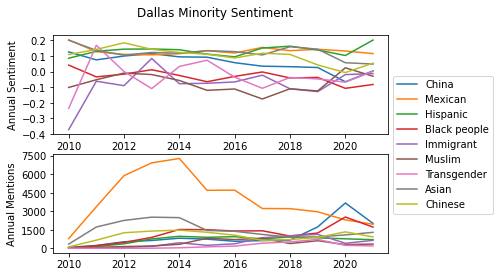

<Figure size 1080x2160 with 0 Axes>

In [23]:
maxTweets = [x for x in maxTweets if math.isnan(x) == False]
maxSentiment = np.asarray(maxSentiment).flatten()
maxSentiment = maxSentiment[~np.isnan(maxSentiment)]
maxSentScore = maxSentiment.max()
minSentScore = maxSentiment.min()
print(maxSentScore)
fig, (ax1,ax2) = plt.subplots(2)
if county == '':
    county = 'Texas'
fig.suptitle(county.capitalize() + ' Minority Sentiment')
ax1.set_ylabel('Annual Sentiment')
ax2.set_ylabel('Annual Mentions')
ax1.set_yticks(np.arange(round(minSentScore-.1,1), round(maxSentScore+.1,1), .1))
ax2.set_yticks(np.arange(0, np.amax(maxTweets), round(np.amax(maxTweets)/10,-2)))
for i in range(len(topKeys)):topKeys[i] = topKeys[i].capitalize()
for j in range(0,len(remappedData)-1):
    x_2,y = zip(*mentionsKeyword[keyWords[j]])
    x_1,=zip(*(remappedData[j]))
    x_2 = list(x_2)
    x_1 = list(x_1)
    ax1.plot(yearList,x_1,label = topKeys[j])
    ax2.plot(y,x_2)
    nanArray = np.concatenate([np.where(np.isnan(x_1)),np.where(np.isnan(x_2))],axis=None)
    nanArray = np.flip(np.unique(nanArray),axis=None)
    # nanArray is a list of the indecies where all the points in the data would fail due to a nan in the corresponding index somewhere else 



plt.figure(figsize=(15,30))
fig.legend(loc="center left", bbox_to_anchor=(.9,0.5), ncol=1)
fig.savefig('Texas Cumulitive Minority Analysis.png',dpi = 100,facecolor='w', edgecolor='w',orientation='landscape',transparent=False, bbox_inches='tight', pad_inches=0.1)
# make some sort of normalizing function for the popularity of the keywords
print()

In [24]:
print(trendAnalysis)

                   Phrase Frequency  Counties
0  BLACK PEOPLE AND CHINA         1  [DALLAS]
1       ASIAN AND MEXICAN         1  [DALLAS]
2                   CHINA         1  [DALLAS]
3                 MEXICAN         1  [DALLAS]
4            BLACK PEOPLE         1  [DALLAS]
5                  MUSLIM         1  [DALLAS]
